In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Tensorflow Version 2.4.1


In [2]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [5]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

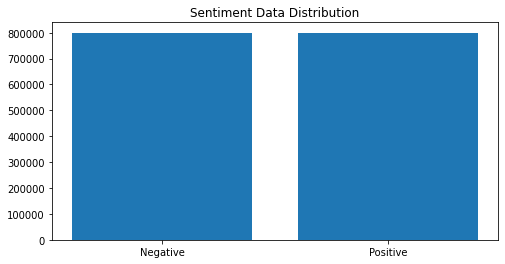

In [6]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [7]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
157795,Negative,@NoeIsaac I still have to see it!!!
346105,Negative,Second BBQ of the year this evening. Then Appr...
714117,Negative,@slpnbuuuty Ouch! Was there blood? Are you g...
1009455,Positive,Yay! Passed.
911022,Positive,@kakakatey That's cause Ovie is the one man te...
969008,Positive,@garykarr just one good one?! Btw - Amy looked...
1568705,Positive,driver goes FREE at Agroventures: http://twirl...
1088619,Positive,ok im finna lay it down. its been fun...1st da...
693640,Negative,I miss my computer
625696,Negative,@courgamm i can't see the picture tell me wha...


In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [10]:
df.text = df.text.apply(lambda x: preprocess(x))
device = "cuda:0"

## Train and Test Split

In [11]:
TRAIN_SIZE = 0.8 
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 10
LR = 1e-3
BATCH_SIZE = 4096
EPOCHS = 10

In [12]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [14]:
import os 
with open('twitter_dictionary.txt', 'w') as file:
    for key in word_index.keys():
        file.write(key + " " + str(word_index[key]) + ",")

In [15]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

print(type(x_train))
print(type(x_test))

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  34, 110], dtype=int32)

In [17]:
labels = train_data.sentiment.unique().tolist()

In [18]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last = True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last = True)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [19]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.conv = nn.Conv1d(embedding_dim, 8, kernel_size=5)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        #self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        #print(x.shape)
        if len(x) != 1:
            batch_size = x.size(0)
        else:
            batch_size = 1
        x = x.long()
        embeds = self.embedding(x)

        #conv = self.conv(x)
        
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        #hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
        #             weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [20]:
def model_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [21]:
output_size = 1
embedding_dim = 128
hidden_dim = 4
n_layers = 1

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(model_params(model))
model.to(device)
lr=0.008
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


37195749


In [22]:
epochs = 10
counter = 0
print_every = 100
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(BATCH_SIZE)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.unsqueeze(1), labels.float())
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(BATCH_SIZE)
            val_losses = []
            model.eval()
            for inp, lab in test_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.unsqueeze(1), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/10... Step: 100... Loss: 0.595616... Val Loss: 0.559234
Validation loss decreased (inf --> 0.559234).  Saving model ...
Epoch: 1/10... Step: 200... Loss: 0.560503... Val Loss: 0.525385
Validation loss decreased (0.559234 --> 0.525385).  Saving model ...
Epoch: 1/10... Step: 300... Loss: 0.543411... Val Loss: 0.509830
Validation loss decreased (0.525385 --> 0.509830).  Saving model ...
Epoch: 2/10... Step: 400... Loss: 0.535628... Val Loss: 0.499954
Validation loss decreased (0.509830 --> 0.499954).  Saving model ...
Epoch: 2/10... Step: 500... Loss: 0.515044... Val Loss: 0.494356
Validation loss decreased (0.499954 --> 0.494356).  Saving model ...
Epoch: 2/10... Step: 600... Loss: 0.516833... Val Loss: 0.489569
Validation loss decreased (0.494356 --> 0.489569).  Saving model ...
Epoch: 3/10... Step: 700... Loss: 0.504902... Val Loss: 0.483323
Validation loss decreased (0.489569 --> 0.483323).  Saving model ...
Epoch: 3/10... Step: 800... Loss: 0.504520... Val Loss: 0.479524
Va

In [23]:
h = model.init_hidden(1)

In [24]:
sentence = "I love my life"
trial = torch.tensor(pad_sequences(tokenizer.texts_to_sequences([sentence]), maxlen = MAX_SEQUENCE_LENGTH)).to(device)
print(trial)

model(trial, h)[0]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9, 98]], device='cuda:0',
       dtype=torch.int32)


tensor([0.9145], device='cuda:0', grad_fn=<SelectBackward>)

In [25]:
import torch.onnx
torch.onnx.export(model,               # model being run
                  (trial, (torch.randn(1,1,4).to(device), torch.randn(1,1,4).to(device))),                   # model input (or a tuple for multiple inputs)
                  "lstm-PT.onnx")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/opt/conda/lib/python3.7/site-packages/torch/onnx/symbolic_opset9.py:1805: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")
